# 3D Lattice Pattern Explorer

Interactive notebook for creating 3D lattices and setting geometric patterns.

## Contents
1. Creating Lattices
2. Pattern Primitives (Sphere, Cube, Cylinder, etc.)
3. Gradients and Waves
4. Noise Patterns
5. Special Patterns (Gyroid, Voronoi, etc.)
6. Pattern Composition
7. Custom Functions
8. Differentiable Lattices for Training

In [1]:
# Imports
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Our modules
from tensor_lattice import Tensor3DLattice, DifferentiableTensor3DLattice, create_lattice_from_tensor
from lattice_patterns import PatternGenerator, Pattern3D, FalloffType

print("Imports successful!")

Imports successful!


---
## 1. Creating Lattices

Create 3D lattices with different topologies:
- **bounded**: Regular 3D grid with edges
- **toroidal**: Wrap-around in all dimensions (like a 3-torus)
- **cylindrical**: Wrap-around in 2 dimensions

In [2]:
# Define lattice size
SHAPE = (24, 24, 24)

# Create lattices with different topologies
lattice_bounded = Tensor3DLattice(shape=SHAPE, topology='bounded')
lattice_toroidal = Tensor3DLattice(shape=SHAPE, topology='toroidal')
lattice_cylindrical = Tensor3DLattice(shape=SHAPE, topology='cylindrical')

print(f"Created lattices with shape {SHAPE}")
print(f"\nBounded lattice stats: {lattice_bounded.get_stats()}")
print(f"\nToroidal lattice stats: {lattice_toroidal.get_stats()}")

Created lattices with shape (24, 24, 24)

Bounded lattice stats: {'shape': (24, 24, 24), 'total_cells': 13824, 'cells_in_memory': 0, 'active_cells': 0, 'topology': 'bounded', 'connectivity': '6-connected', 'wrap_dims': (False, False, False)}

Toroidal lattice stats: {'shape': (24, 24, 24), 'total_cells': 13824, 'cells_in_memory': 0, 'active_cells': 0, 'topology': 'toroidal', 'connectivity': '6-connected', 'wrap_dims': (True, True, True)}


In [3]:
# Compare neighbor counts at edges vs center
for name, lattice in [('bounded', lattice_bounded), ('toroidal', lattice_toroidal)]:
    corner_neighbors = len(lattice.get_neighbors(lattice.get_idx(0, 0, 0)))
    center_neighbors = len(lattice.get_neighbors(lattice.get_idx(12, 12, 12)))
    print(f"{name}: corner has {corner_neighbors} neighbors, center has {center_neighbors} neighbors")

bounded: corner has 3 neighbors, center has 6 neighbors
toroidal: corner has 6 neighbors, center has 6 neighbors


---
## 2. Pattern Primitives

Create basic geometric shapes: spheres, cubes, cylinders, cones, torus, planes.

In [4]:
# Create a pattern generator for our lattice shape
pg = PatternGenerator(shape=SHAPE)

# Helper function to visualize 3D patterns as slices
def show_pattern_slices(pattern, title="Pattern", n_slices=5):
    """Show pattern as horizontal slices."""
    # Extract data and ensure it's a numpy array
    data = pattern.data if hasattr(pattern, 'data') else pattern
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    
    fig, axes = plt.subplots(1, n_slices, figsize=(15, 3))
    slice_indices = [int(i) for i in np.linspace(0, data.shape[2]-1, n_slices)]
    
    vmin, vmax = float(data.min()), float(data.max())
    for ax, z in zip(axes, slice_indices):
        im = ax.imshow(data[:, :, z], cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(f'z={z}')
        ax.axis('off')
    
    plt.suptitle(f'{title} (range: [{vmin:.2f}, {vmax:.2f}])')
    plt.colorbar(im, ax=axes, shrink=0.8)
    plt.tight_layout()
    plt.show()

print("Helper function defined!")

Helper function defined!


Sphere patterns with different falloffs:


/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


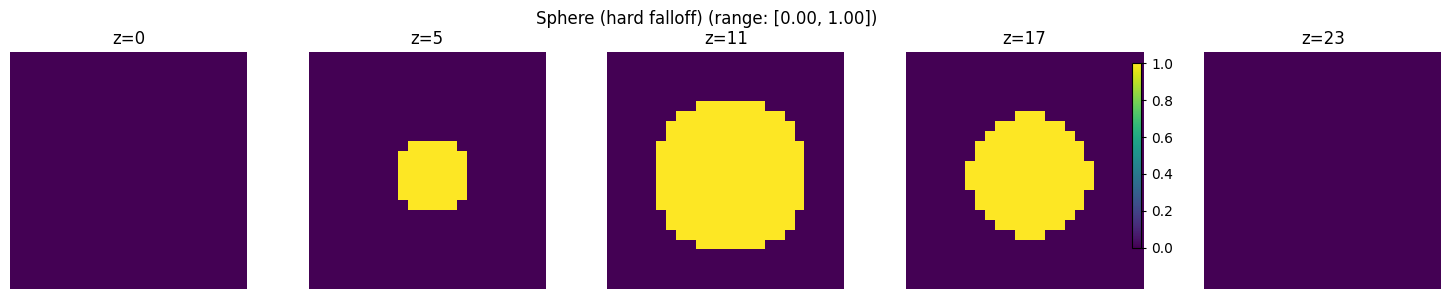

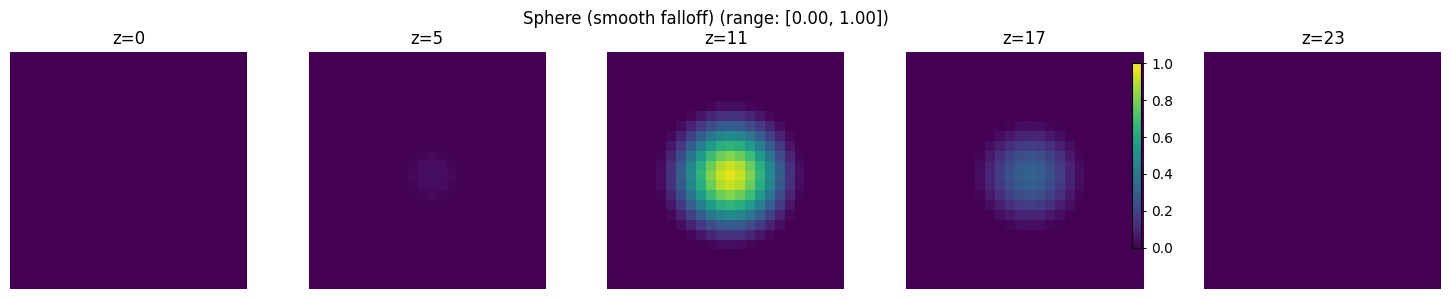

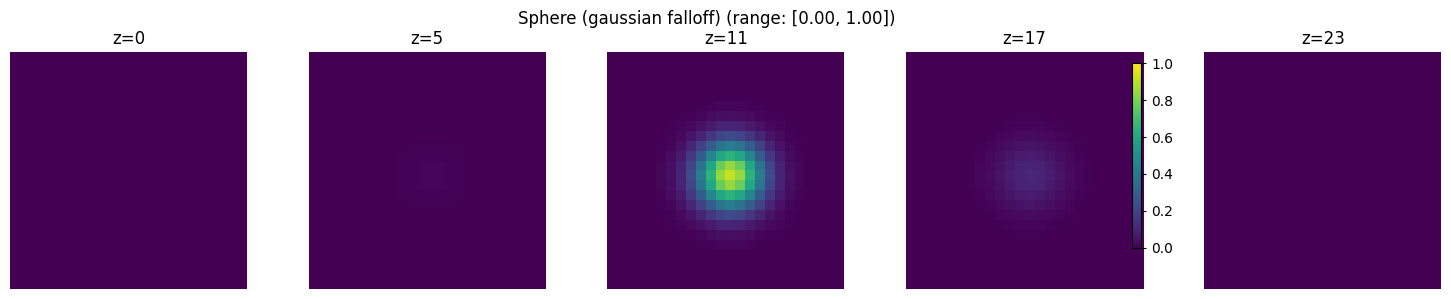

In [5]:
# Sphere with different falloff types
sphere_hard = pg.sphere(radius=8, falloff='hard')
sphere_smooth = pg.sphere(radius=8, falloff='smooth')
sphere_gaussian = pg.sphere(radius=8, falloff='gaussian')

print("Sphere patterns with different falloffs:")
show_pattern_slices(sphere_hard, "Sphere (hard falloff)")
show_pattern_slices(sphere_smooth, "Sphere (smooth falloff)")
show_pattern_slices(sphere_gaussian, "Sphere (gaussian falloff)")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


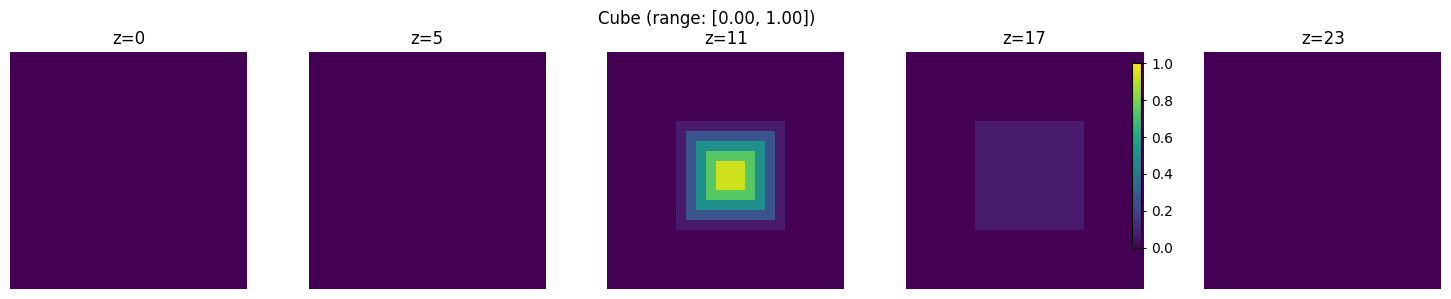

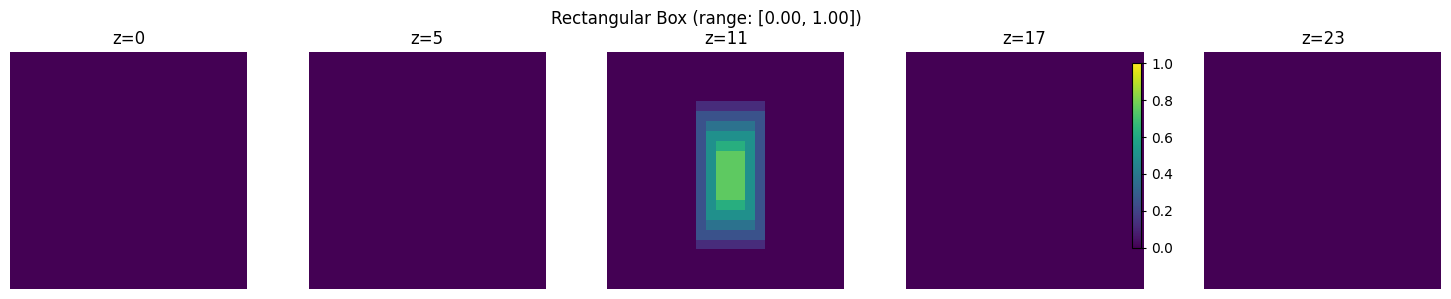

In [6]:
# Cube
cube = pg.cube(size=12, falloff='smooth')
show_pattern_slices(cube, "Cube")

# Rectangular box
box = pg.cube(size=(16, 8, 8), falloff='linear')
show_pattern_slices(box, "Rectangular Box")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


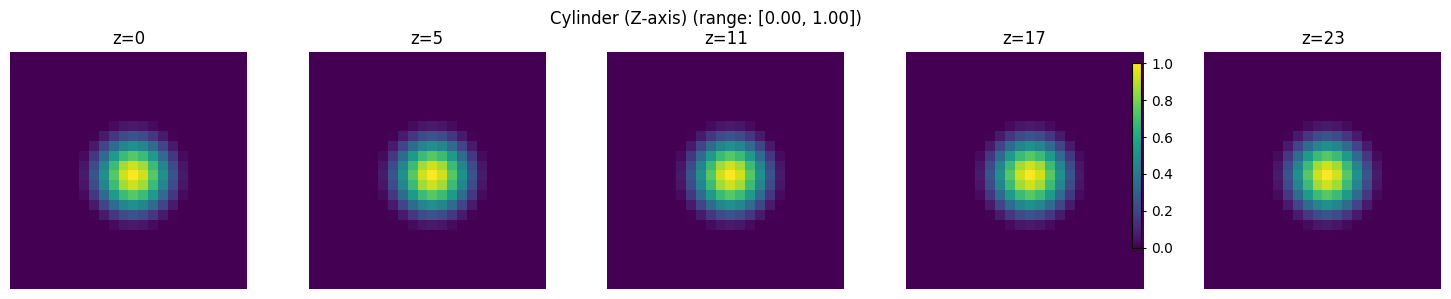

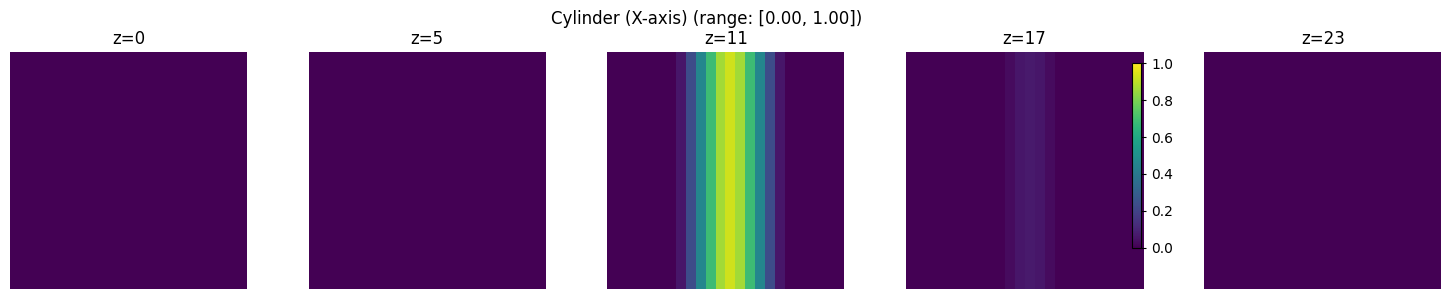

In [7]:
# Cylinders along different axes
cylinder_z = pg.cylinder(radius=6, axis='z', falloff='smooth')
cylinder_x = pg.cylinder(radius=6, axis='x', falloff='smooth')

show_pattern_slices(cylinder_z, "Cylinder (Z-axis)")
show_pattern_slices(cylinder_x, "Cylinder (X-axis)")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


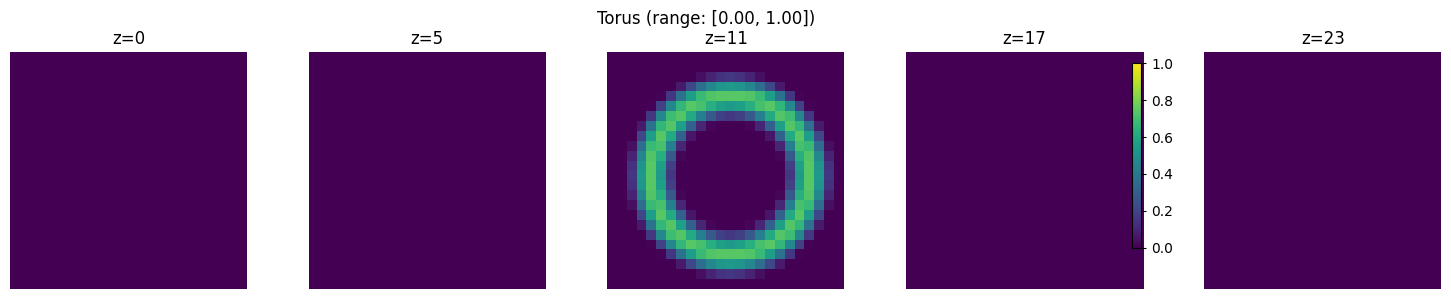

In [8]:
# Torus
torus = pg.torus(major_radius=8, minor_radius=3, axis='z', falloff='smooth')
show_pattern_slices(torus, "Torus")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


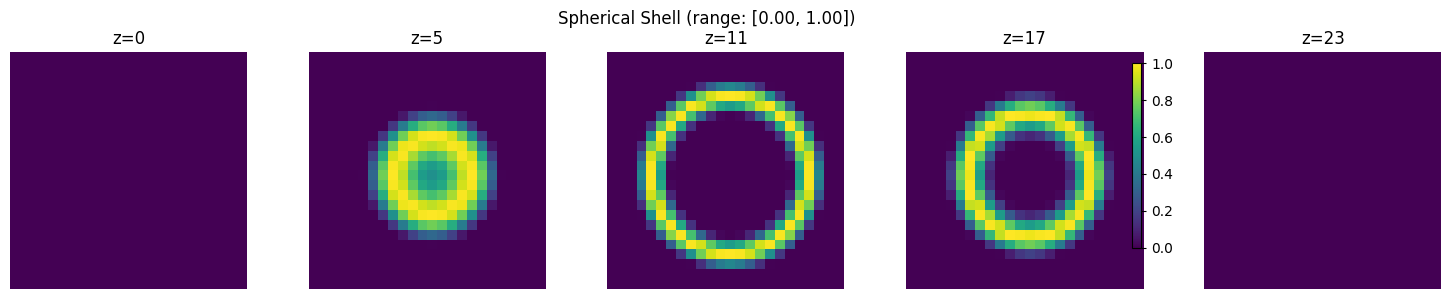

In [9]:
# Shell (hollow sphere)
shell = pg.shell(inner_radius=6, outer_radius=10, falloff='smooth')
show_pattern_slices(shell, "Spherical Shell")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


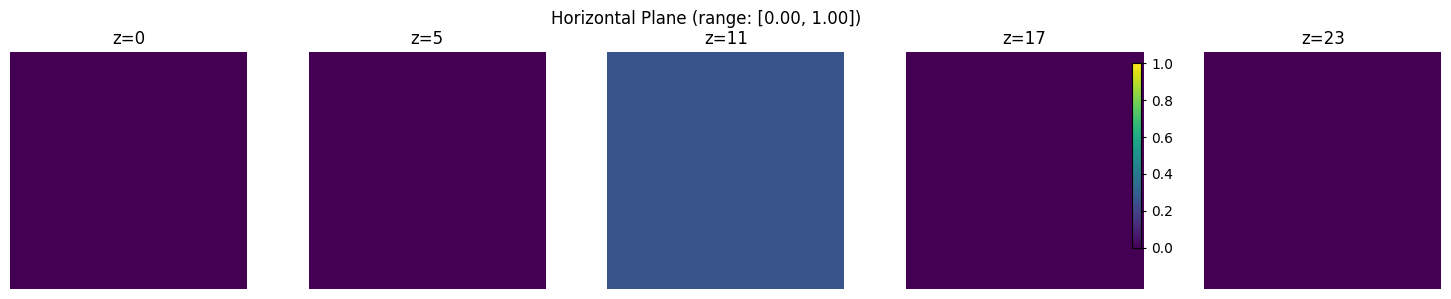

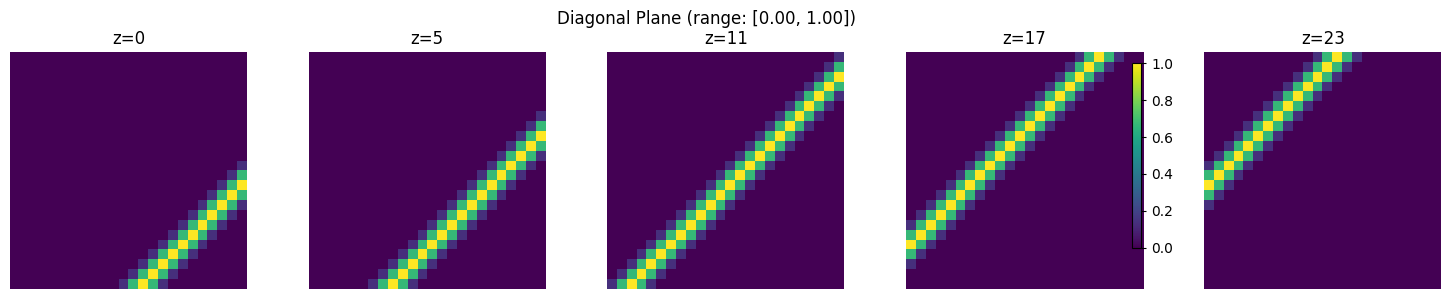

In [10]:
# Plane slices at different angles
plane_z = pg.plane(normal=(0, 0, 1), thickness=3, falloff='smooth')  # Horizontal
plane_diag = pg.plane(normal=(1, 1, 1), thickness=3, falloff='smooth')  # Diagonal

show_pattern_slices(plane_z, "Horizontal Plane")
show_pattern_slices(plane_diag, "Diagonal Plane")

---
## 3. Gradients and Waves

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


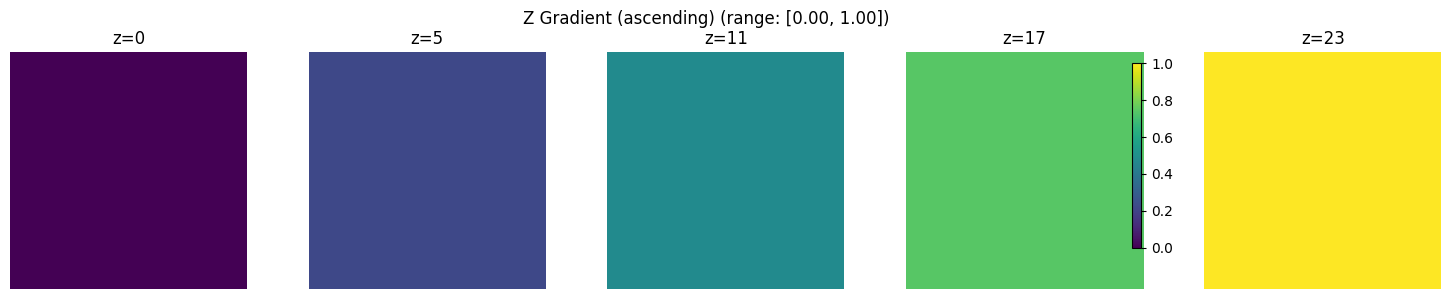

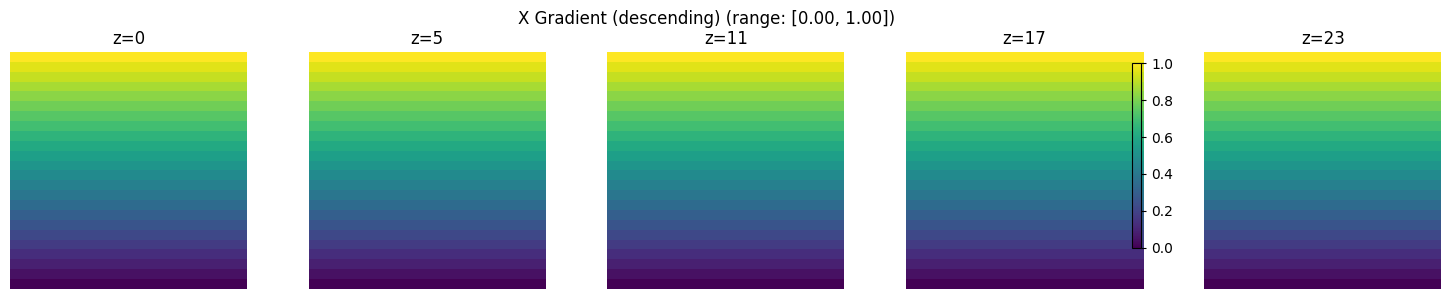

In [11]:
# Linear gradients
grad_z = pg.gradient(axis='z', direction='ascending')
grad_x = pg.gradient(axis='x', direction='descending')

show_pattern_slices(grad_z, "Z Gradient (ascending)")
show_pattern_slices(grad_x, "X Gradient (descending)")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


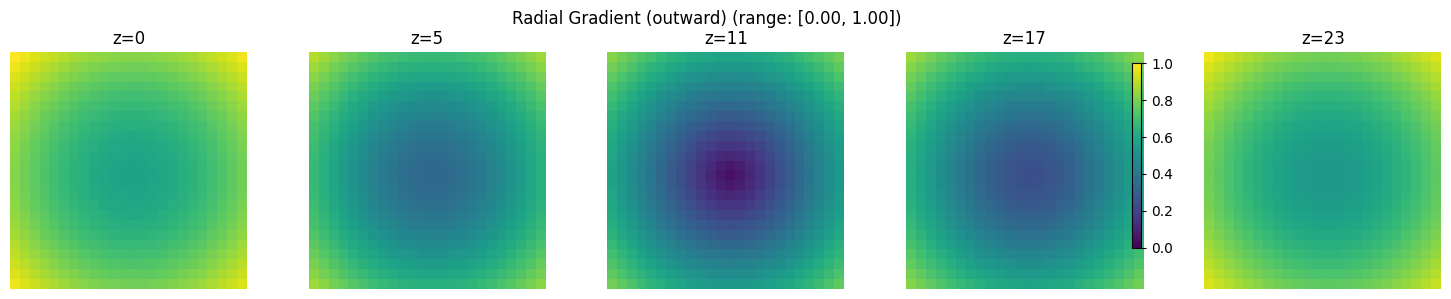

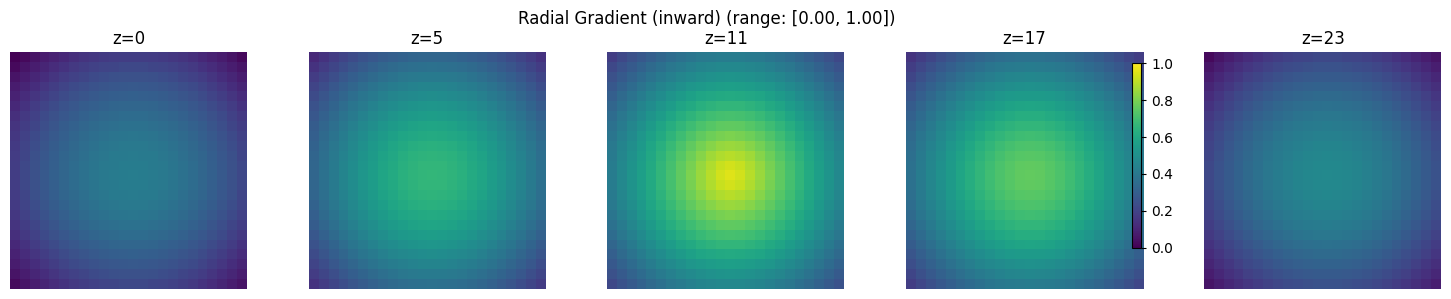

In [12]:
# Radial gradient
radial_out = pg.radial_gradient(direction='outward')
radial_in = pg.radial_gradient(direction='inward')

show_pattern_slices(radial_out, "Radial Gradient (outward)")
show_pattern_slices(radial_in, "Radial Gradient (inward)")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


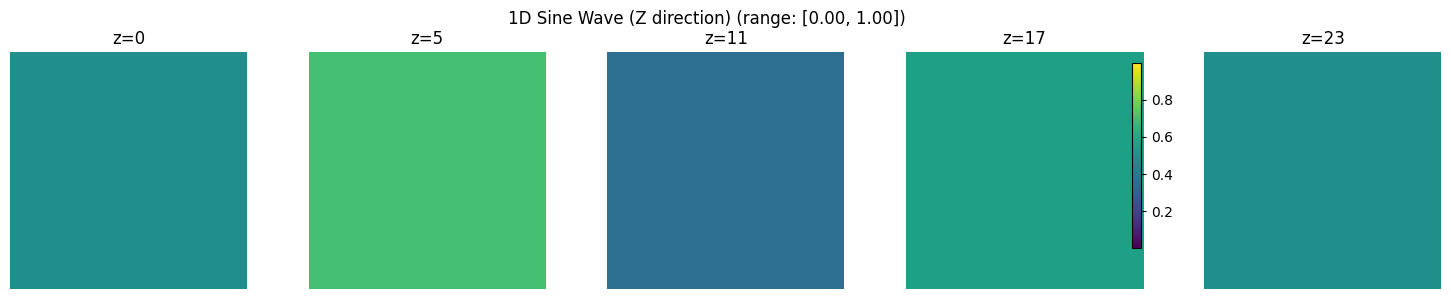

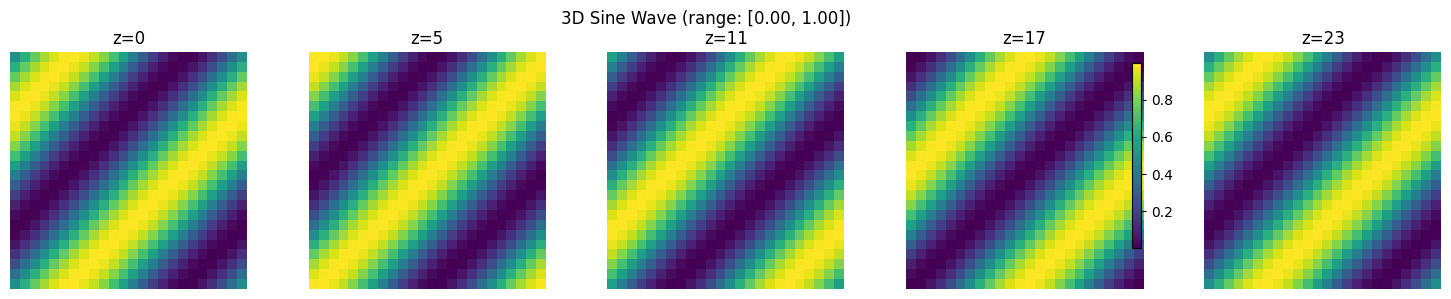

In [13]:
# Sine waves
wave_1d = pg.sine_wave(frequency=(0, 0, 2), amplitude=0.5, offset=0.5)
wave_3d = pg.sine_wave(frequency=(1, 1, 1), amplitude=0.5, offset=0.5)

show_pattern_slices(wave_1d, "1D Sine Wave (Z direction)")
show_pattern_slices(wave_3d, "3D Sine Wave")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


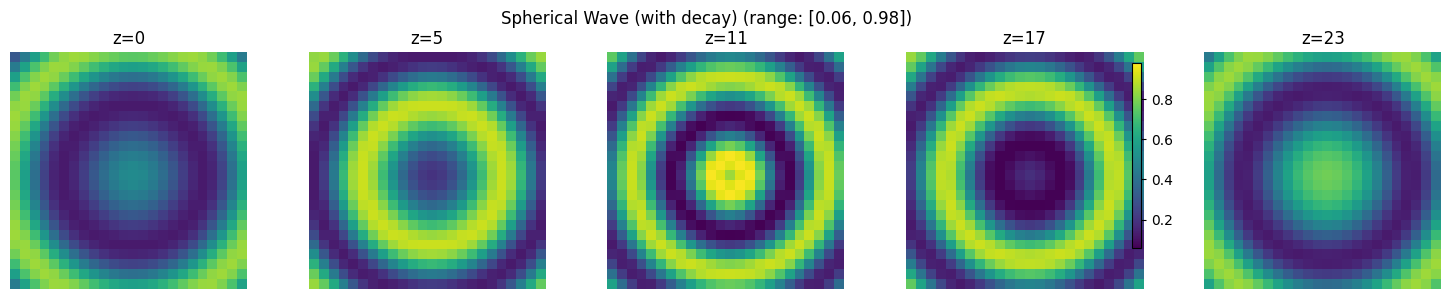

In [14]:
# Spherical waves (concentric)
spherical_wave = pg.spherical_wave(frequency=3, decay=0.5)
show_pattern_slices(spherical_wave, "Spherical Wave (with decay)")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


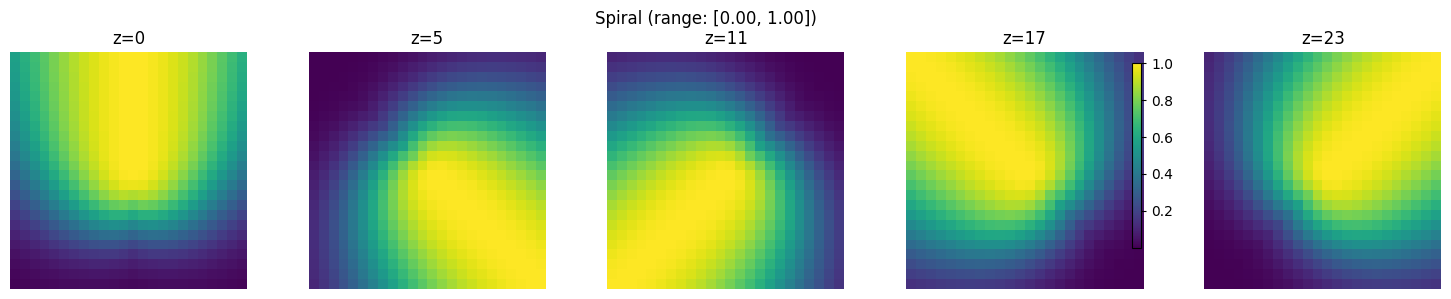

In [15]:
# Spiral
spiral = pg.spiral(turns=3, thickness=2, axis='z')
show_pattern_slices(spiral, "Spiral")

---
## 4. Noise Patterns

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


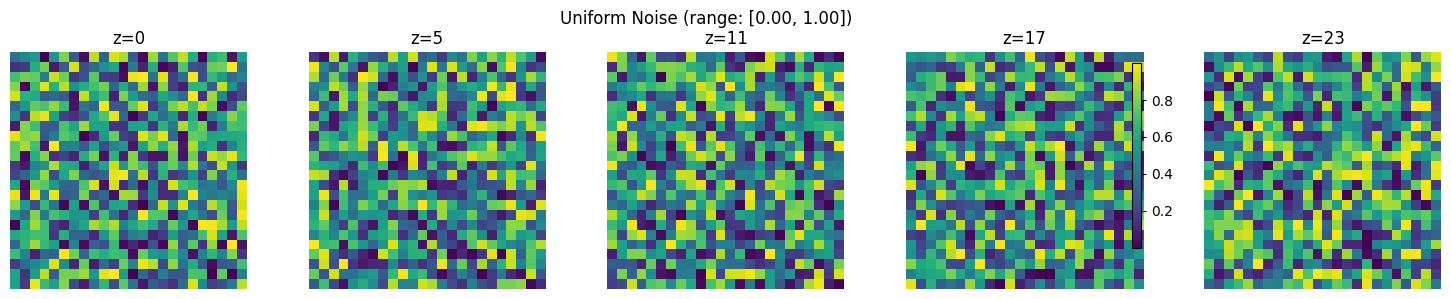

In [16]:
# Uniform noise
uniform_noise = pg.noise(scale=1.0, seed=42)
show_pattern_slices(uniform_noise, "Uniform Noise")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


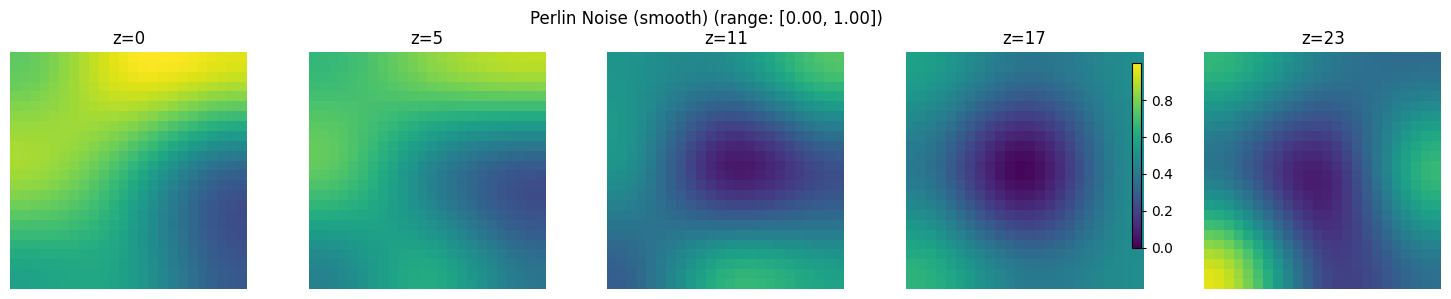

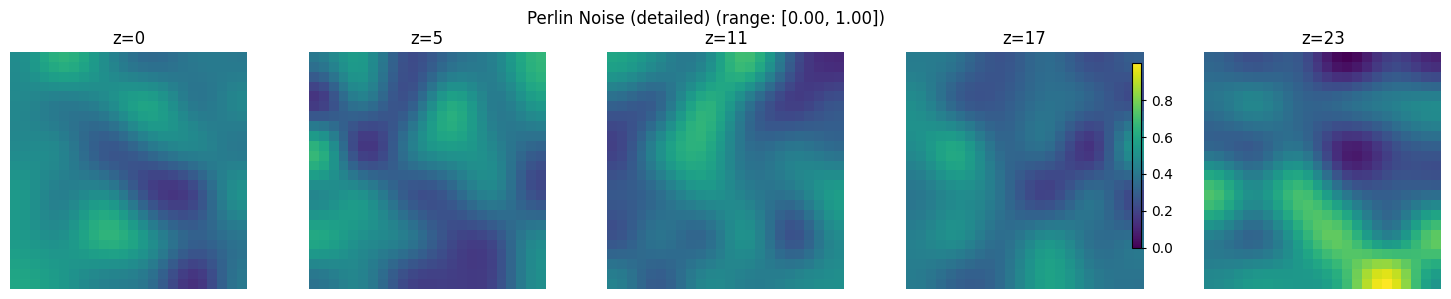

In [17]:
# Perlin noise with different settings
perlin_smooth = pg.perlin_noise(scale=8, octaves=2, seed=42)
perlin_detailed = pg.perlin_noise(scale=4, octaves=6, persistence=0.6, seed=42)

show_pattern_slices(perlin_smooth, "Perlin Noise (smooth)")
show_pattern_slices(perlin_detailed, "Perlin Noise (detailed)")

---
## 5. Special Patterns

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


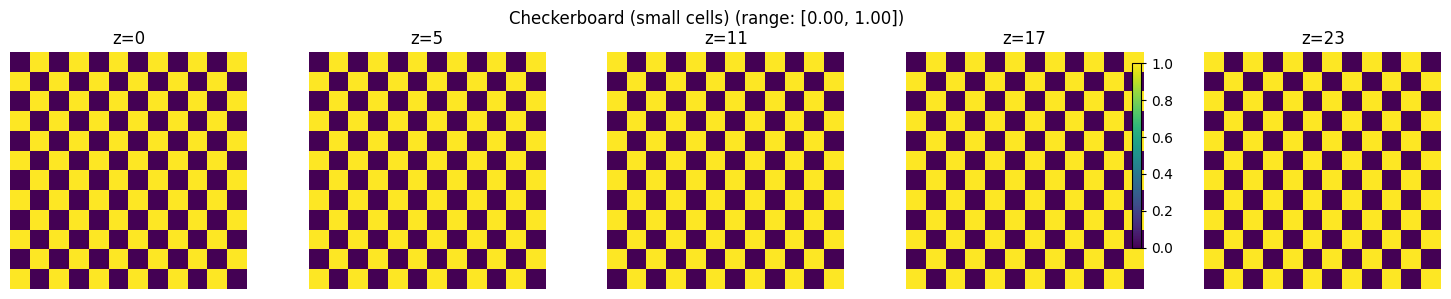

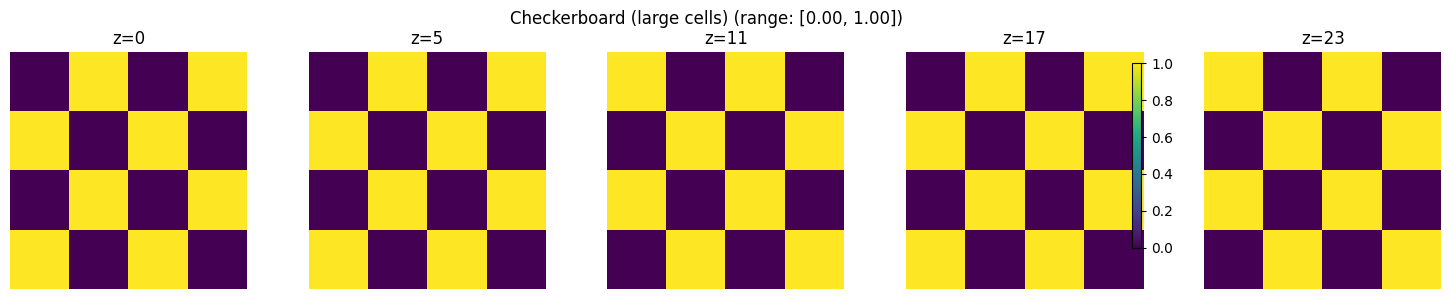

In [18]:
# Checkerboard
checker_small = pg.checkerboard(cell_size=2)
checker_large = pg.checkerboard(cell_size=6)

show_pattern_slices(checker_small, "Checkerboard (small cells)")
show_pattern_slices(checker_large, "Checkerboard (large cells)")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


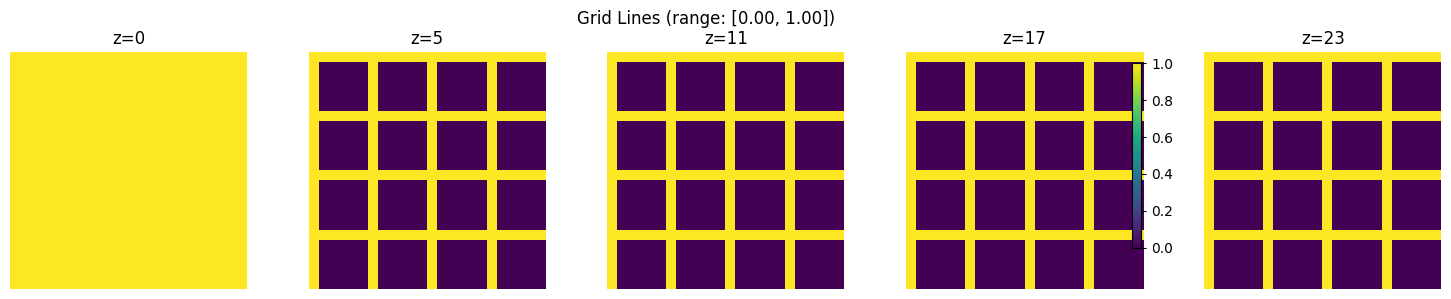

In [19]:
# Grid lines
grid = pg.grid_lines(spacing=6, thickness=1)
show_pattern_slices(grid, "Grid Lines")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


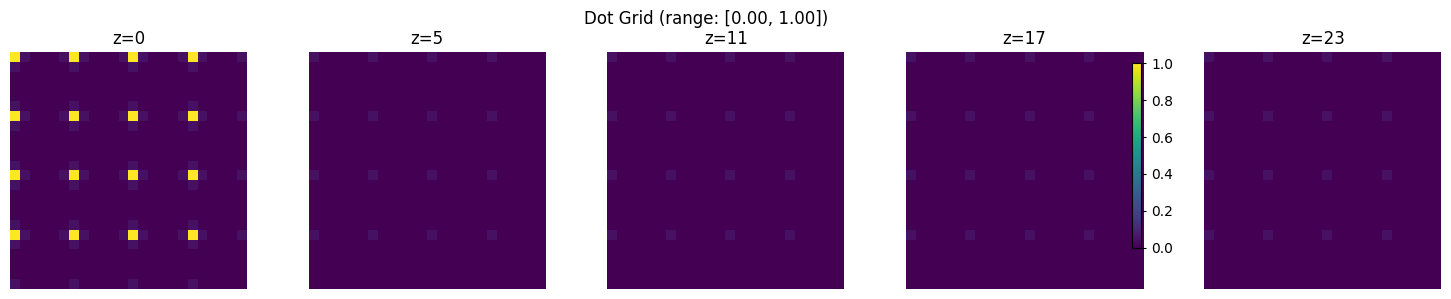

In [20]:
# Dots pattern
dots = pg.dots(spacing=6, radius=2, falloff='gaussian')
show_pattern_slices(dots, "Dot Grid")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


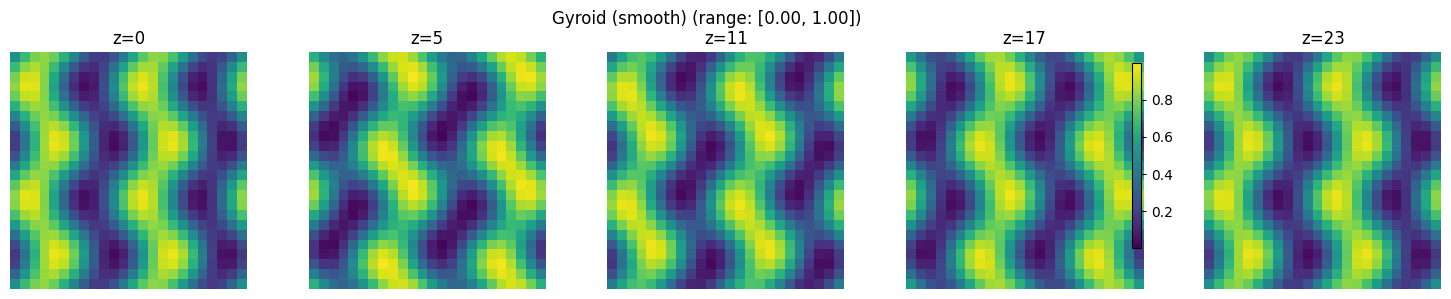

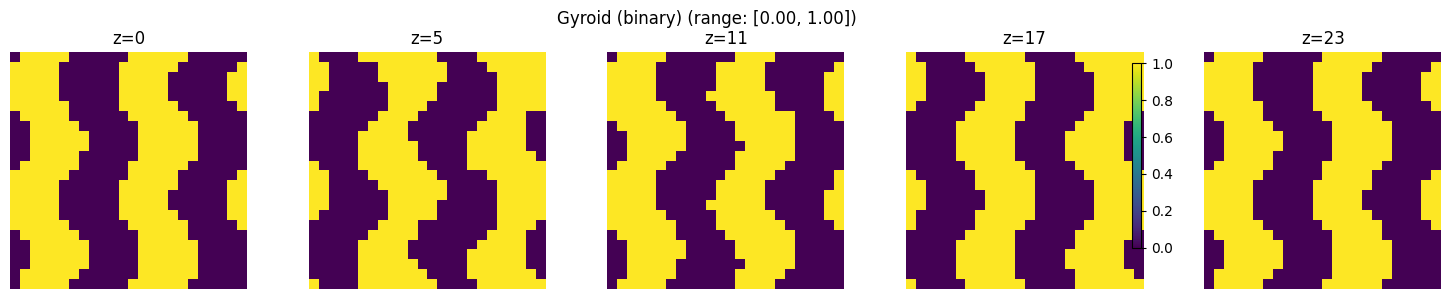

In [21]:
# Gyroid (minimal surface)
gyroid_smooth = pg.gyroid(scale=2, smooth=True)
gyroid_binary = pg.gyroid(scale=2, smooth=False, threshold=0.0)

show_pattern_slices(gyroid_smooth, "Gyroid (smooth)")
show_pattern_slices(gyroid_binary, "Gyroid (binary)")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


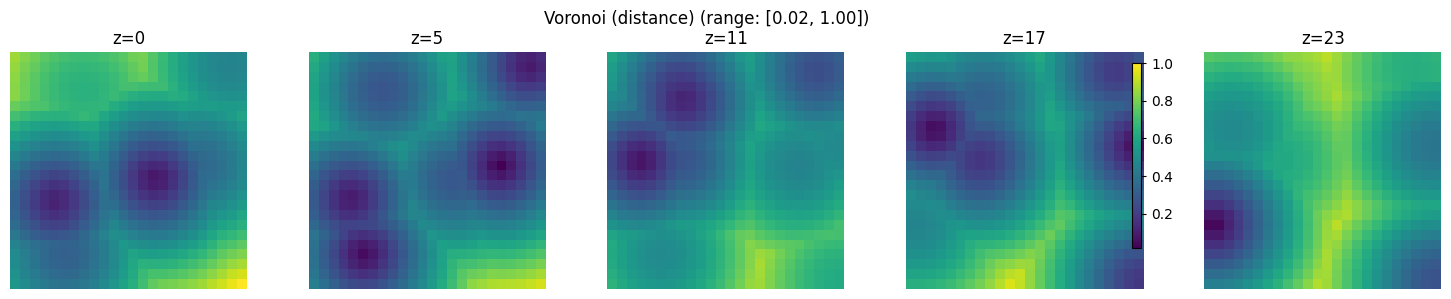

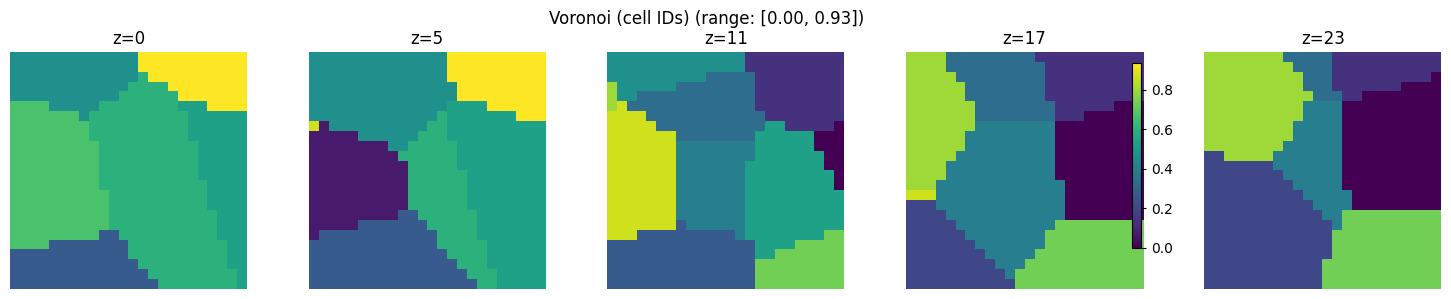

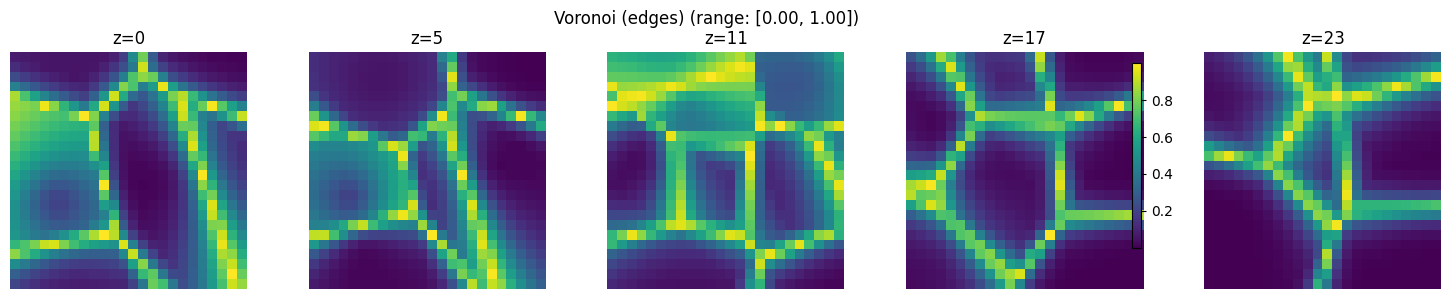

In [22]:
# Voronoi patterns
voronoi_dist = pg.voronoi(n_points=15, mode='distance', seed=42)
voronoi_cells = pg.voronoi(n_points=15, mode='cell_id', seed=42)
voronoi_edges = pg.voronoi(n_points=15, mode='edge', seed=42)

show_pattern_slices(voronoi_dist, "Voronoi (distance)")
show_pattern_slices(voronoi_cells, "Voronoi (cell IDs)")
show_pattern_slices(voronoi_edges, "Voronoi (edges)")

---
## 6. Pattern Composition

Combine patterns using arithmetic operations and composition functions.

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


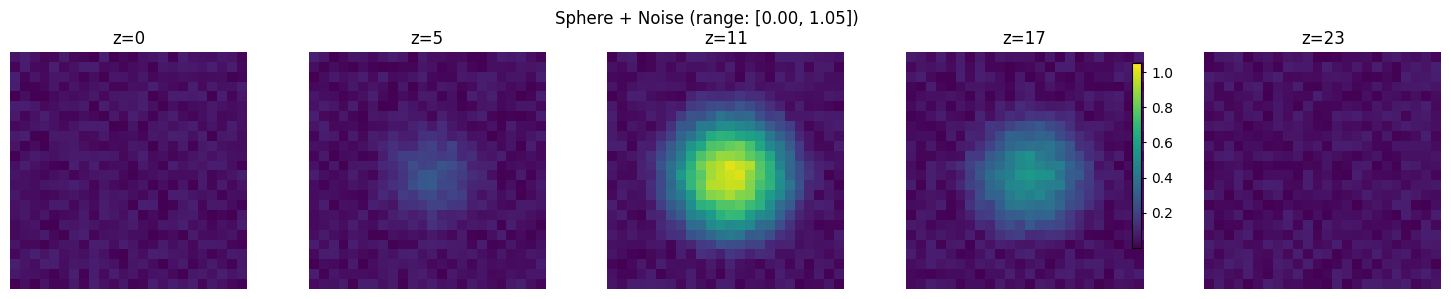

In [23]:
# Pattern arithmetic
sphere = pg.sphere(radius=10, falloff='smooth')
noise = pg.noise(scale=0.3)

# Add noise to sphere
noisy_sphere = sphere + noise * 0.3
show_pattern_slices(noisy_sphere, "Sphere + Noise")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


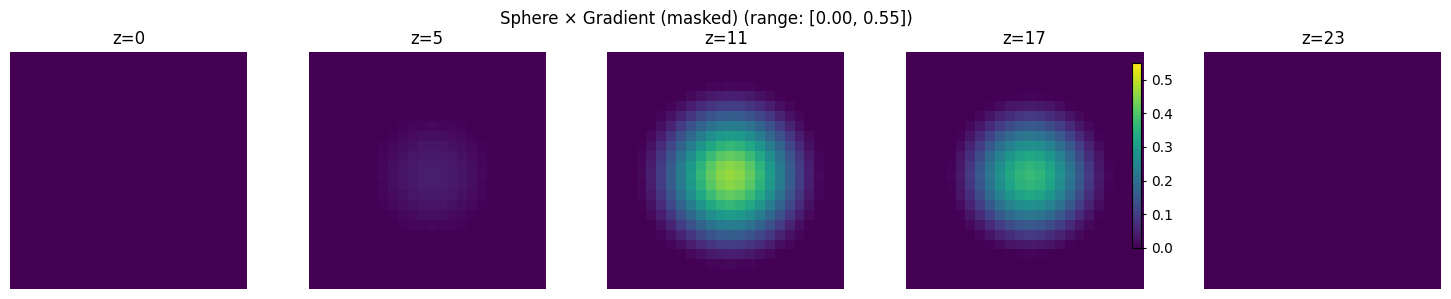

In [24]:
# Multiply patterns (masking)
gradient = pg.gradient(axis='z')
masked_sphere = sphere * gradient
show_pattern_slices(masked_sphere, "Sphere × Gradient (masked)")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


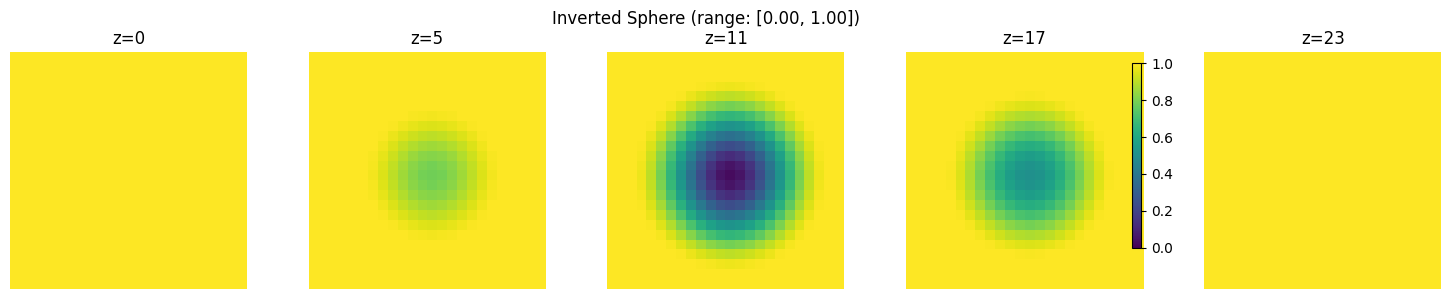

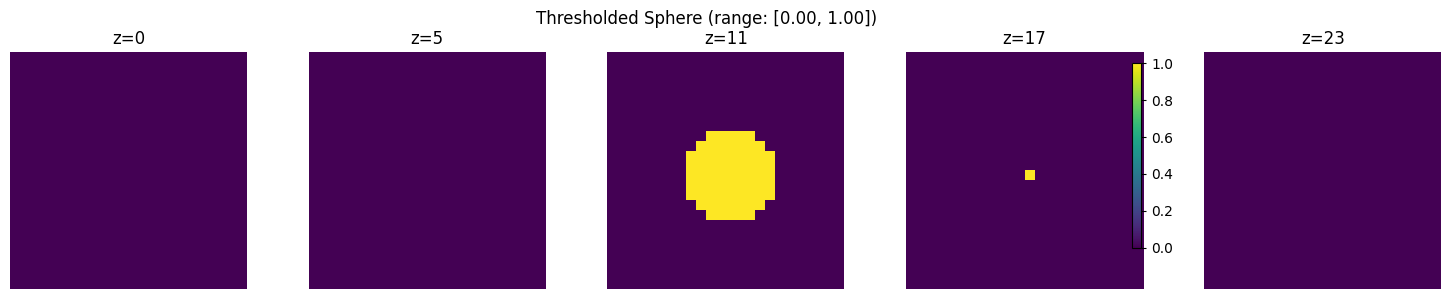

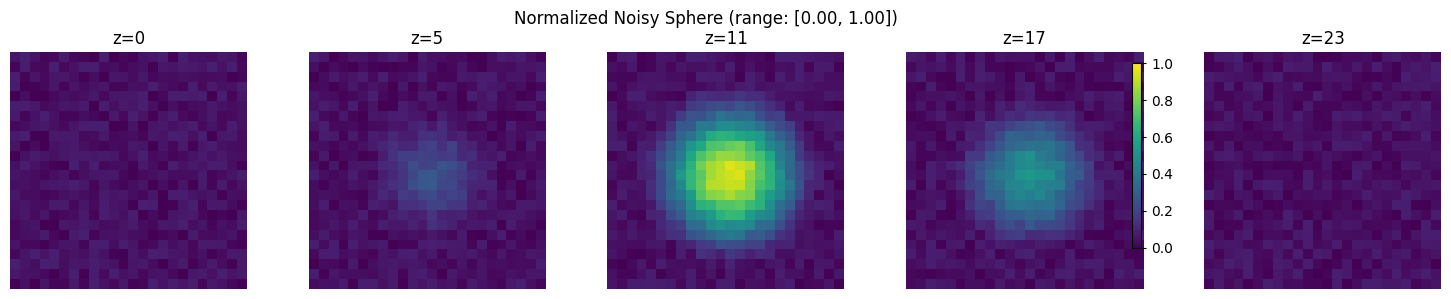

In [25]:
# Pattern operations
inverted = sphere.invert()
thresholded = sphere.threshold(0.5)
normalized = noisy_sphere.normalize(0, 1)

show_pattern_slices(inverted, "Inverted Sphere")
show_pattern_slices(thresholded, "Thresholded Sphere")
show_pattern_slices(normalized, "Normalized Noisy Sphere")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


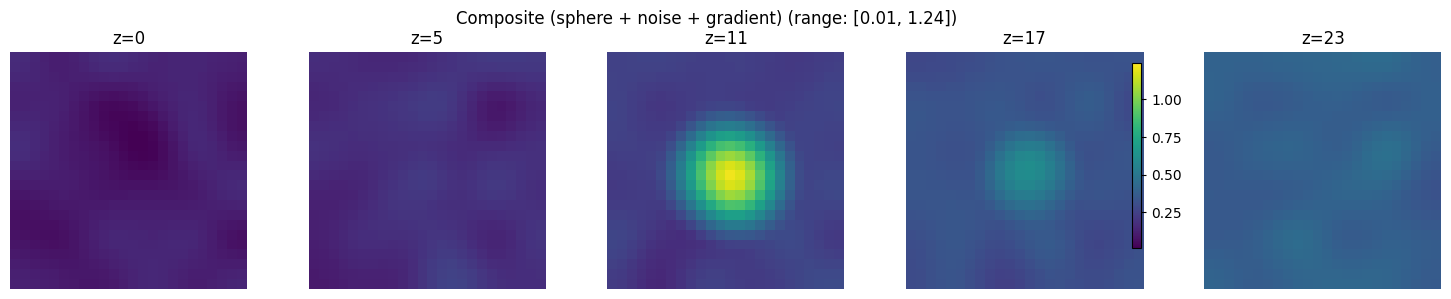

In [26]:
# Use compose() for complex combinations
composite = pg.compose([
    ('sphere', {'radius': 8, 'falloff': 'smooth'}, 1.0),
    ('perlin_noise', {'scale': 4, 'octaves': 3}, 0.2),
    ('gradient', {'axis': 'z'}, 0.3)
], mode='add')

show_pattern_slices(composite, "Composite (sphere + noise + gradient)")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


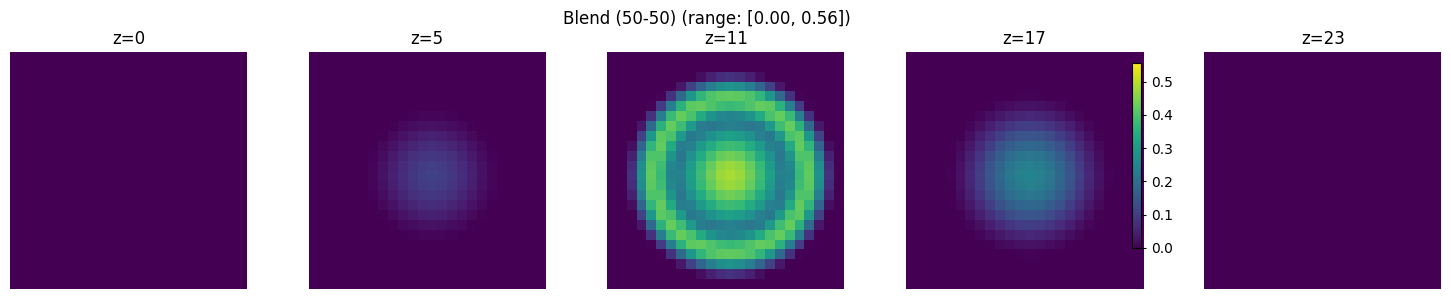

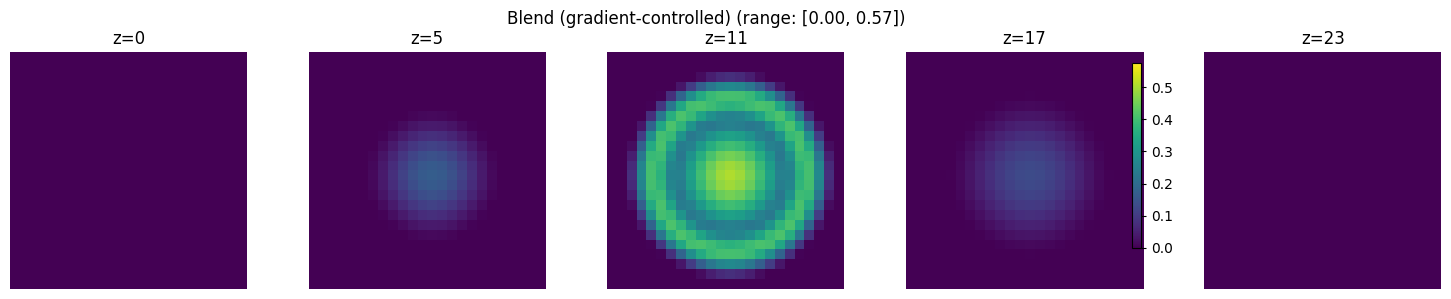

In [27]:
# Blend patterns
sphere = pg.sphere(radius=10)
torus = pg.torus(major_radius=8, minor_radius=3)

# 50-50 blend
blend_50 = pg.blend(sphere, torus, 0.5)

# Gradient-controlled blend
blend_gradient = pg.blend(sphere, torus, gradient)

show_pattern_slices(blend_50, "Blend (50-50)")
show_pattern_slices(blend_gradient, "Blend (gradient-controlled)")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


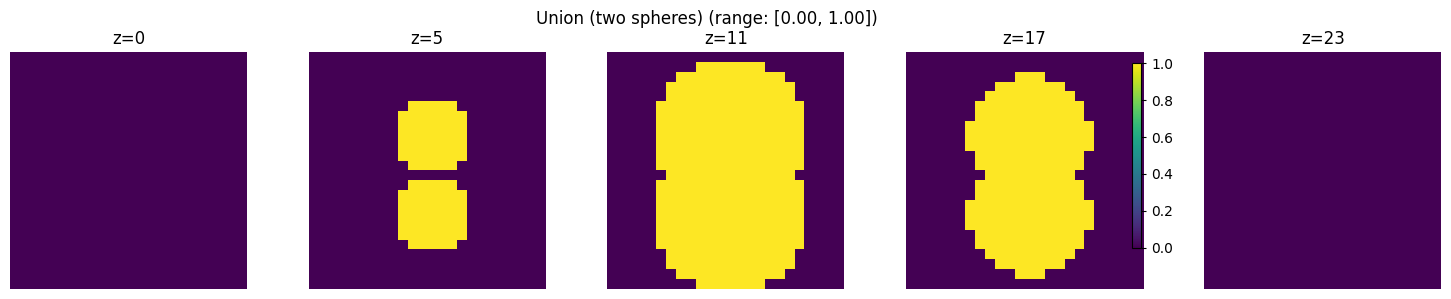

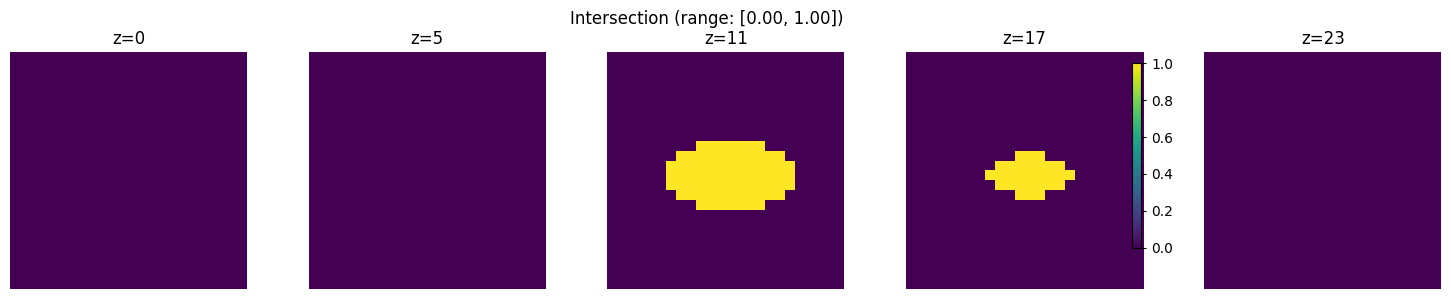

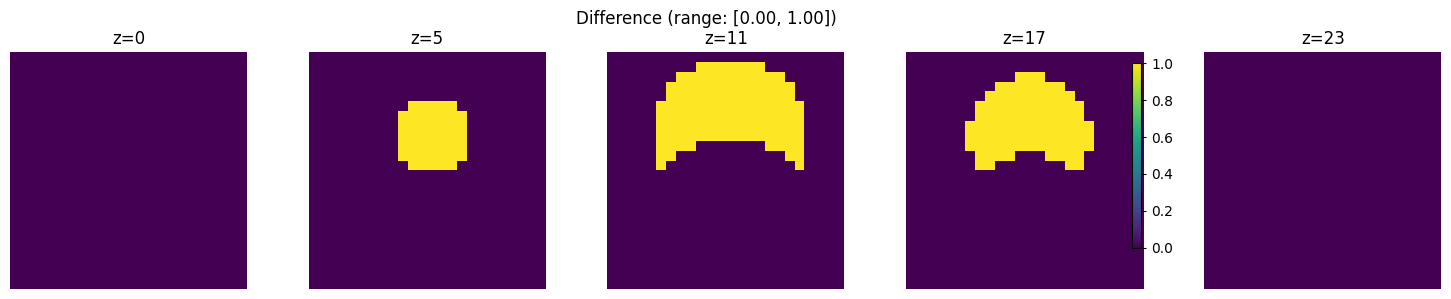

In [28]:
# Boolean-like operations
sphere1 = pg.sphere(center=(8, 12, 12), radius=8, falloff='hard')
sphere2 = pg.sphere(center=(16, 12, 12), radius=8, falloff='hard')

# Union (max)
union = Pattern3D(
    data=np.maximum(sphere1.data, sphere2.data),
    name='union', params={}
)

# Intersection (min)
intersection = Pattern3D(
    data=np.minimum(sphere1.data, sphere2.data),
    name='intersection', params={}
)

# Difference
difference = Pattern3D(
    data=np.maximum(sphere1.data - sphere2.data, 0),
    name='difference', params={}
)

show_pattern_slices(union, "Union (two spheres)")
show_pattern_slices(intersection, "Intersection")
show_pattern_slices(difference, "Difference")

---
## 7. Custom Functions

Create patterns from custom mathematical functions.

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


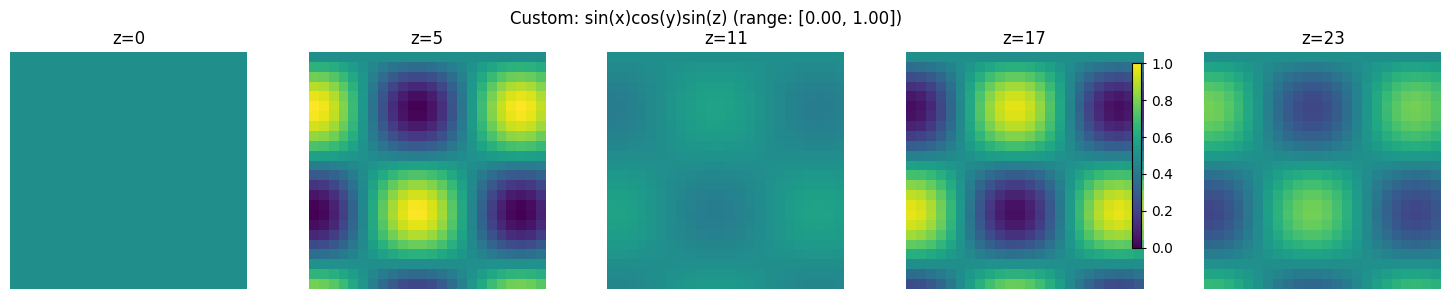

In [29]:
# Custom function using normalized coordinates
custom1 = pg.from_function(
    lambda I, J, K: np.sin(I * 0.3) * np.cos(J * 0.3) * np.sin(K * 0.3),
    name='trigonometric'
)
show_pattern_slices(custom1.normalize(), "Custom: sin(x)cos(y)sin(z)")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


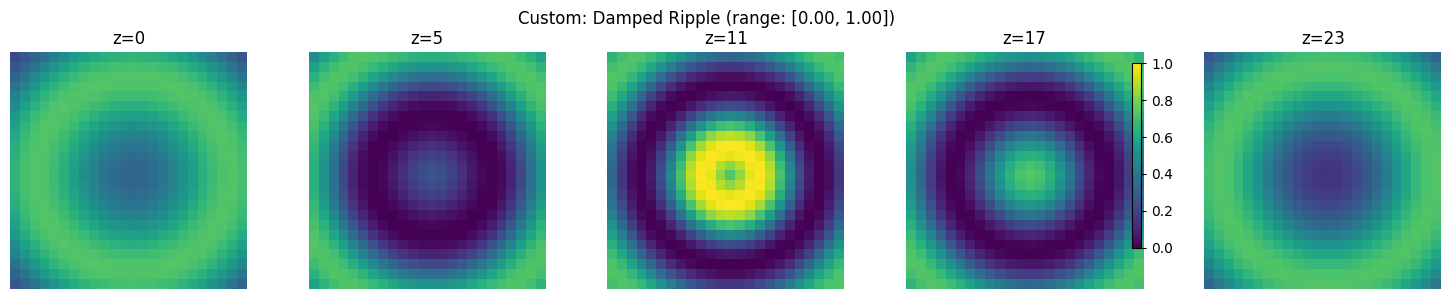

In [30]:
# Distance-based custom function
def ripple_func(I, J, K):
    cx, cy, cz = SHAPE[0]/2, SHAPE[1]/2, SHAPE[2]/2
    dist = np.sqrt((I - cx)**2 + (J - cy)**2 + (K - cz)**2)
    return np.sin(dist * 0.5) * np.exp(-dist * 0.05)

ripple = pg.from_function(ripple_func, name='ripple')
show_pattern_slices(ripple.normalize(), "Custom: Damped Ripple")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


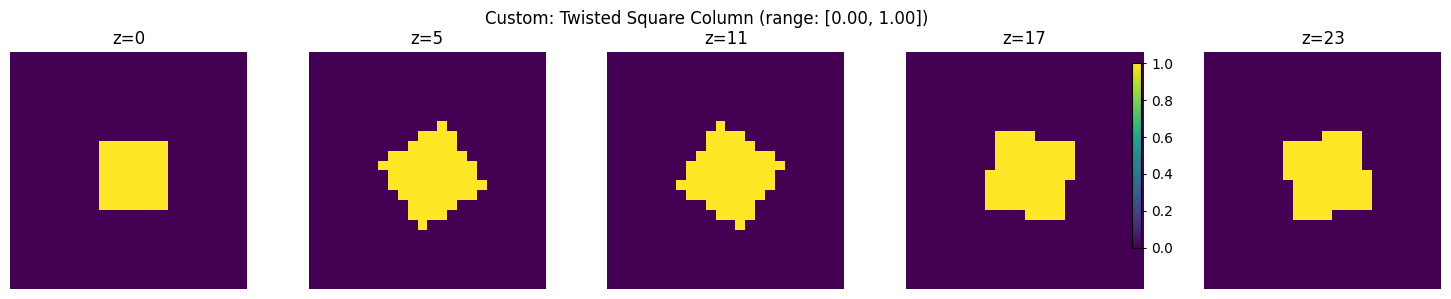

In [31]:
# Twisted coordinates
def twisted_func(I, J, K):
    cx, cy = SHAPE[0]/2, SHAPE[1]/2
    # Angle based on height
    angle = K * 0.2
    # Rotated coordinates
    x_rot = (I - cx) * np.cos(angle) - (J - cy) * np.sin(angle)
    y_rot = (I - cx) * np.sin(angle) + (J - cy) * np.cos(angle)
    # Square cross-section
    return (np.abs(x_rot) < 4) & (np.abs(y_rot) < 4)

twisted = pg.from_function(twisted_func, name='twisted')
show_pattern_slices(twisted, "Custom: Twisted Square Column")

---
## 8. Setting Patterns on Lattices

Apply patterns to actual lattice structures.

Lattice tensor shape: torch.Size([24, 24, 24])
Value range: [0.000, 1.000]


/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


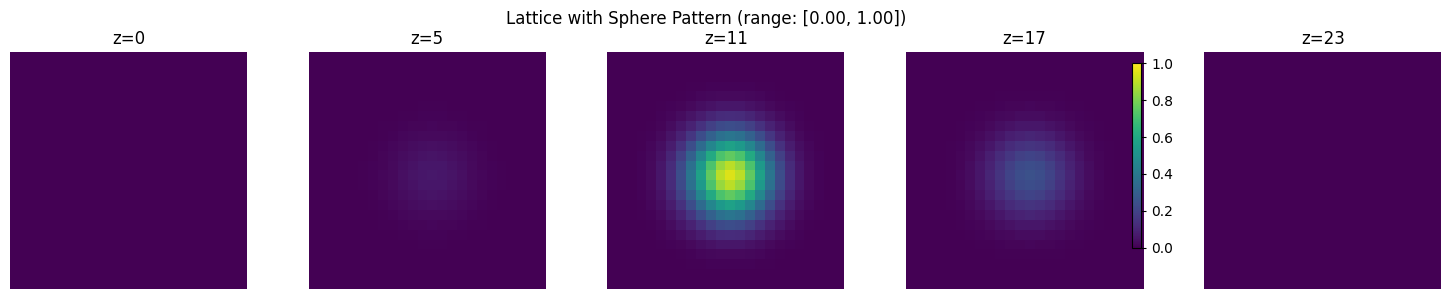

In [32]:
# Create a fresh lattice
lattice = Tensor3DLattice(shape=SHAPE, topology='toroidal')

# Set pattern using name (simple API)
lattice.set_pattern('sphere', radius=10, falloff='gaussian')

# Convert to tensor and visualize
tensor = lattice.to_tensor()
print(f"Lattice tensor shape: {tensor.shape}")
print(f"Value range: [{tensor.min():.3f}, {tensor.max():.3f}]")

show_pattern_slices(tensor.cpu().numpy(), "Lattice with Sphere Pattern")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


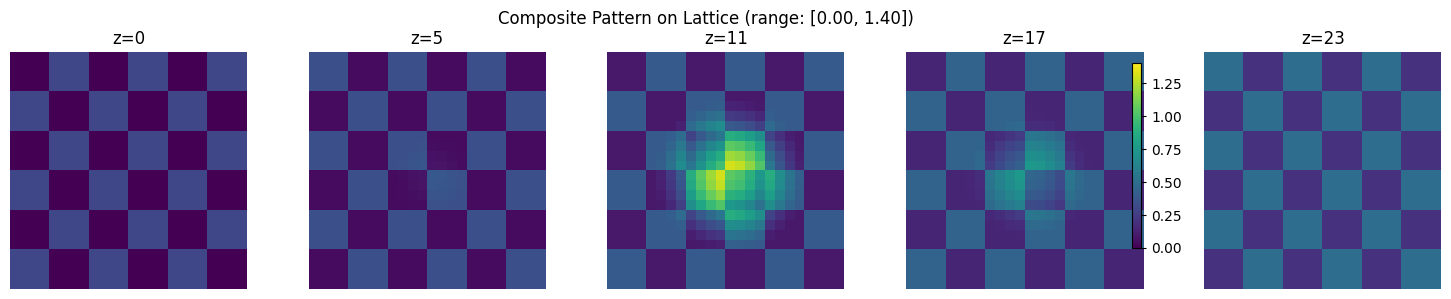

In [33]:
# Set composite pattern
lattice.set_composite_pattern([
    ('sphere', {'radius': 8}, 1.0),
    ('checkerboard', {'cell_size': 4}, 0.3),
    ('gradient', {'axis': 'z'}, 0.2)
], mode='add')

show_pattern_slices(lattice.to_tensor().cpu().numpy(), "Composite Pattern on Lattice")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


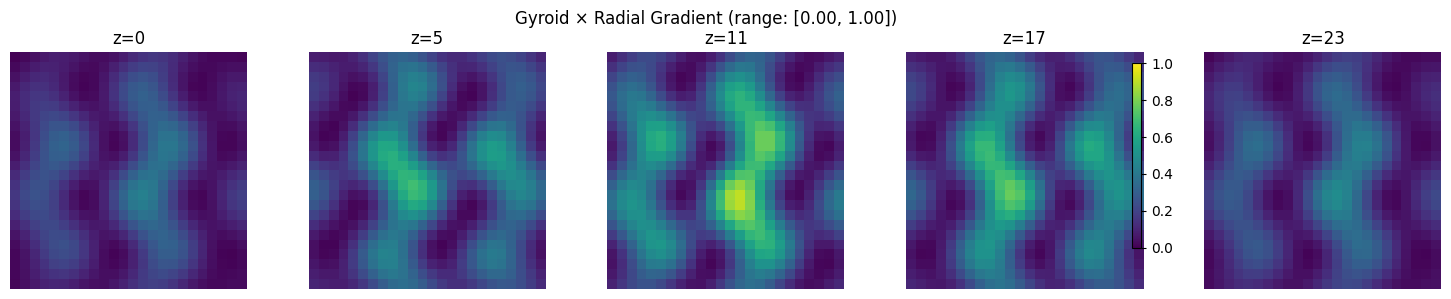

In [34]:
# Set pattern from Pattern3D object
pg = lattice.get_pattern_generator()
my_pattern = pg.gyroid(scale=2) * pg.radial_gradient(direction='inward')
my_pattern = my_pattern.normalize()

lattice.set_pattern(my_pattern)
show_pattern_slices(lattice.to_tensor().cpu().numpy(), "Gyroid × Radial Gradient")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


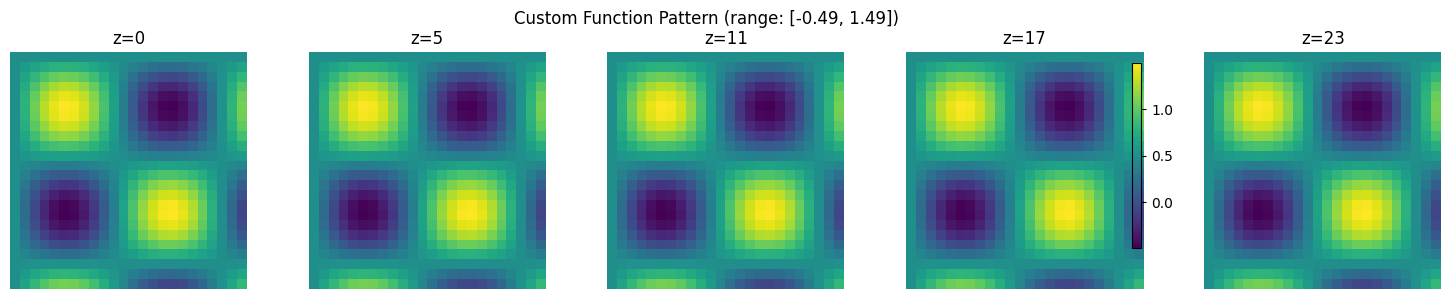

In [35]:
# Set pattern from custom function
lattice.set_from_function(
    lambda i, j, k: np.sin(i * 0.3) * np.sin(j * 0.3) + 0.5
)
show_pattern_slices(lattice.to_tensor().cpu().numpy(), "Custom Function Pattern")

/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


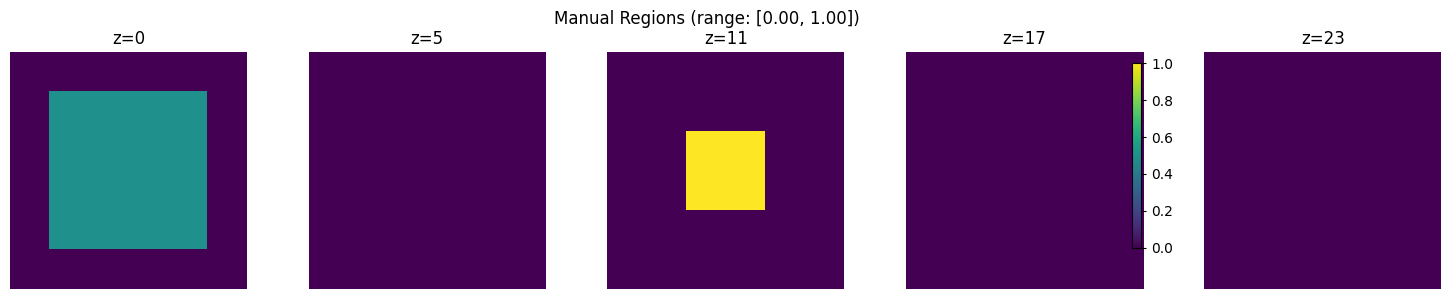

In [36]:
# Set specific region
lattice.clear_pattern(value=0.0)  # Reset to zero

# Set a cube region
lattice.set_region(
    (slice(8, 16), slice(8, 16), slice(8, 16)),  # Region
    value=1.0
)

# Set another region with different value
lattice.set_region(
    (slice(4, 20), slice(4, 20), slice(0, 4)),
    value=0.5
)

show_pattern_slices(lattice.to_tensor().cpu().numpy(), "Manual Regions")

---
## 9. Differentiable Lattices for Training

Initialize learnable parameters with patterns.

In [37]:
# Create differentiable lattice
diff_lattice = DifferentiableTensor3DLattice(
    shape=SHAPE,
    topology='toroidal',
    connectivity='6-connected',
    max_steps=10
)

print(f"Differentiable lattice created")
print(f"Parameters: {sum(p.numel() for p in diff_lattice.parameters())}")

Differentiable lattice created
Parameters: 55307


Cell weights initialized
Weights range: [0.000, 1.000]


/var/folders/7l/gy9qf7w15p9f0nq52yk14jjw0000gr/T/ipykernel_2387/967732525.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


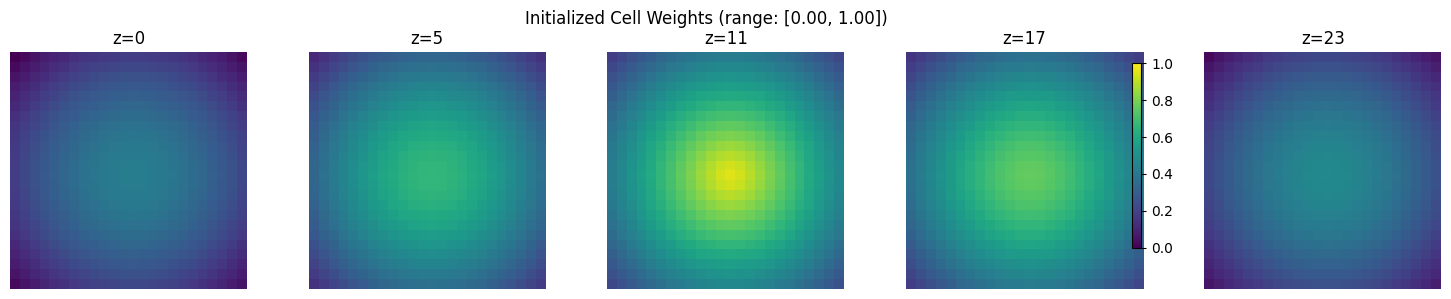

In [38]:
# Initialize cell weights from pattern
diff_lattice.init_cell_weights_from_pattern(
    'radial_gradient',
    direction='inward'
)

print(f"Cell weights initialized")
print(f"Weights range: [{diff_lattice.cell_weights.min():.3f}, {diff_lattice.cell_weights.max():.3f}]")

# Visualize
weights_3d = diff_lattice.cell_weights.reshape(SHAPE).detach().cpu().numpy()
show_pattern_slices(weights_3d, "Initialized Cell Weights")

In [39]:
# Initialize bounce angles from pattern
diff_lattice.init_bounce_angles_from_pattern(
    'sphere',
    radius=10,
    falloff='gaussian',
    scale=0.5
)

print(f"Bounce angles initialized")
print(f"Angles range: [{diff_lattice.bounce_angles.min():.3f}, {diff_lattice.bounce_angles.max():.3f}]")

Bounce angles initialized
Angles range: [-0.986, 1.279]


Input shape: torch.Size([2, 24, 24, 24])
Output shape: torch.Size([2, 24, 24, 24])


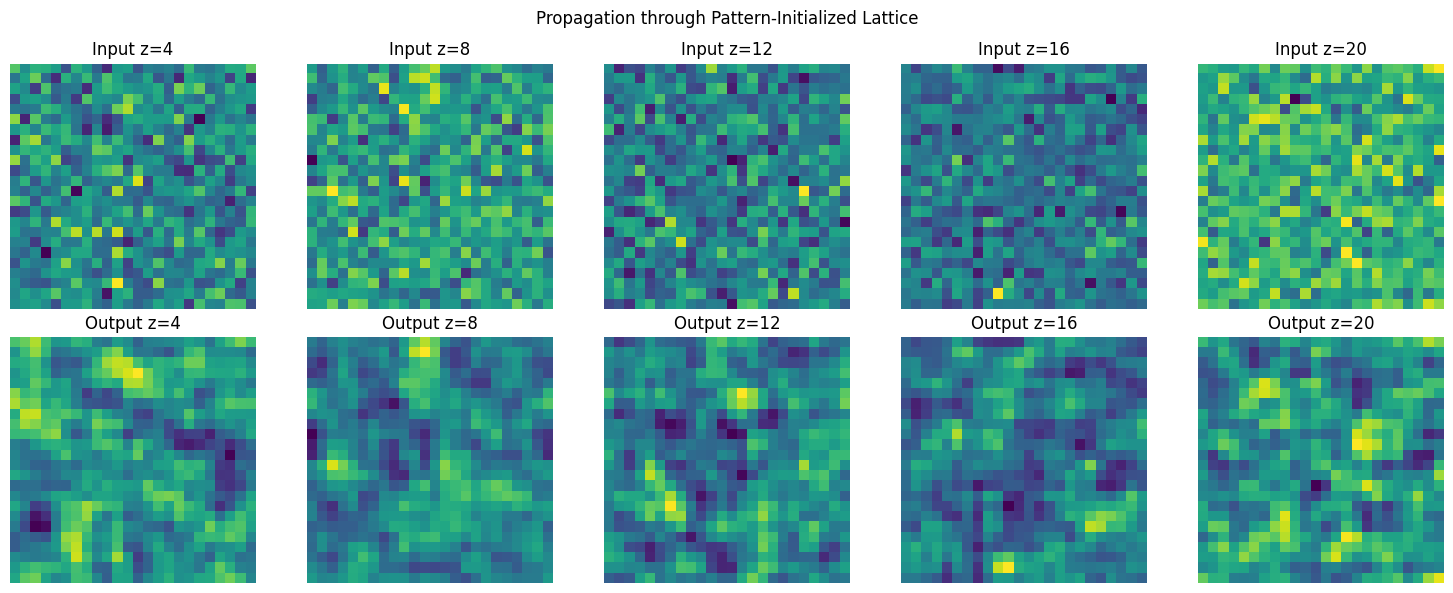

In [40]:
# Test forward pass with pattern-initialized lattice
x = torch.randn(2, *SHAPE)  # Batch of 2 random inputs

# Forward pass
with torch.no_grad():
    output = diff_lattice(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

# Show input vs output for first sample
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, z in enumerate([4, 8, 12, 16, 20]):
    axes[0, i].imshow(x[0, :, :, z].detach().cpu().numpy(), cmap='viridis')
    axes[0, i].set_title(f'Input z={z}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(output[0, :, :, z].detach().cpu().numpy(), cmap='viridis')
    axes[1, i].set_title(f'Output z={z}')
    axes[1, i].axis('off')

plt.suptitle('Propagation through Pattern-Initialized Lattice')
plt.tight_layout()
plt.show()

In [41]:
# Verify gradients flow
x = torch.randn(1, *SHAPE, requires_grad=True)
output = diff_lattice(x)
loss = output.sum()
loss.backward()

print(f"Input gradient exists: {x.grad is not None}")
print(f"Input gradient shape: {x.grad.shape}")
print(f"Parameters with gradients: {sum(p.grad is not None for p in diff_lattice.parameters())}")

Input gradient exists: True
Input gradient shape: torch.Size([1, 24, 24, 24])
Parameters with gradients: 4


---
## 10. Interactive 3D Visualization

In [44]:
# Create a pattern and visualize in 3D using Plotly
lattice = Tensor3DLattice(shape=(16, 16, 16), topology='toroidal')
lattice.set_pattern('gyroid', scale=1.5)

# Get the Plotly figure
fig = lattice.visualize(
    show_values=True,
    cell_size=8,
    opacity=0.8,
    colorscale='Plasma',
    title='3D Gyroid Pattern'
)
fig.show()

In [45]:
# Threshold and visualize only high-value cells
lattice.set_pattern('sphere', radius=6, falloff='hard')

# Only show cells with value > 0.5
tensor = lattice.to_tensor().cpu().numpy()
high_value_mask = tensor > 0.5

# Get positions of high-value cells
positions = np.array(np.where(high_value_mask)).T
values = tensor[high_value_mask]

fig = go.Figure(data=go.Scatter3d(
    x=positions[:, 0],
    y=positions[:, 1],
    z=positions[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color=values,
        colorscale='Viridis',
        opacity=0.8
    )
))

fig.update_layout(
    title='Thresholded Sphere (value > 0.5)',
    scene=dict(aspectmode='data')
)
fig.show()

---
## Summary

This notebook demonstrated:

1. **Creating lattices** with different topologies (bounded, toroidal, cylindrical)
2. **Pattern primitives**: sphere, cube, cylinder, cone, torus, plane, shell
3. **Gradients**: linear and radial
4. **Waves**: sine, spherical, spiral
5. **Noise**: uniform, Perlin
6. **Special patterns**: checkerboard, grid, dots, gyroid, Voronoi
7. **Composition**: arithmetic, blending, boolean operations
8. **Custom functions**: any mathematical formula
9. **Lattice integration**: `set_pattern()`, `set_composite_pattern()`, `set_from_function()`
10. **Differentiable lattices**: pattern-initialized learnable parameters

### Quick Reference

```python
# Create lattice
lattice = Tensor3DLattice(shape=(32, 32, 32), topology='toroidal')

# Set pattern by name
lattice.set_pattern('sphere', radius=10, falloff='smooth')

# Set composite pattern
lattice.set_composite_pattern([
    ('sphere', {'radius': 10}, 1.0),
    ('noise', {'scale': 0.1}, 0.2)
])

# Use pattern generator for complex patterns
pg = lattice.get_pattern_generator()
pattern = pg.gyroid() * pg.radial_gradient()
lattice.set_pattern(pattern.normalize())

# Convert to tensor
tensor = lattice.to_tensor()
```